<a href="https://colab.research.google.com/github/bmreiniger/datascience.stackexchange/blob/master/SO72204836_outlierAUCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyod

     |████████████████████████████████| 120 kB 12.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147473 sha256=8c34baf557ea20725bd6aa4e78ff615213b20611a453abebfdca599f9f591426
  Stored in directory: /root/.cache/pip/wheels/ea/c4/29/67ad87835b209f72e4706369c683741b09490f2829d64ea768
Successfully built pyod
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.




*   Read/Load the anomaly data
*   Simple preprocessing



In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import time
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

Bw = load_breast_cancer(
                        return_X_y=False,
                        as_frame=True)
df = Bw.frame
name_target = 'target'

#change types of feature columns
#df['duration']=df['duration'].astype(float)
#df['src_bytes']=df['src_bytes'].astype(float)
#df['dst_bytes']=df['dst_bytes'].astype(float)

num_row , num_colmn = df.shape

#calculate number of classes
classes = df[name_target].unique()
num_class = len(classes)

print(df[name_target].value_counts())

#determine which class is normal (is not anomaly)
label = np.array(df[name_target])
a,b = np.unique(label , return_counts=True)
#print("a is:",a)
#print("b is:",b)
for i in range(len(b)):
  if b[i]== b.max():
    normal = a[i]
    #print('normal:', normal)
  elif b[i] == b.min():
    unnormal = a[i]
    #print('unnorm:' ,unnormal) 

# show anomaly classes
anomaly_class = []
for f in range(len(a)): 
  if a[f] != normal:
    anomaly_class.append(a[f])

# convert dataset classes to 2 classe: normal and unnormal
label = np.where(label != normal, unnormal ,label)
df[name_target]=label

# showing columns's type: numerical or categorical
numeric =0
categoric = 0
for i in range(df.shape[1]):
  df_col = df.iloc[:,i]
  if df_col.dtype == int and df.columns[i] != name_target:
    numeric +=1
  elif df_col.dtype == float and df.columns[i] != name_target:
    numeric += 1
  elif df.columns[i] != name_target:
    categoric += 1

#replace labels with 0 and 1
label = np.where(label == normal, 0 ,1)
df[name_target]=label


# null_check: if more than half of a column was null, then that columns will be droped
# otherwise if number of null was less than half of column, then nulls will replace with mean of that column
test = []
for i in range(df.shape[1]):
  if df.iloc[:,i].isnull().sum() > df.shape[0]//2:
    test.append(i)
  elif df.iloc[:,i].isnull().sum() < df.shape[0]//2 and df.iloc[:,i].isnull().sum() != 0:
    m = df.iloc[:,i].mean()
    df.iloc[:,i] = df.iloc[:,i].replace(to_replace = np.nan, value = m)
df = df.drop(columns=df.columns[test])



#calculate anomaly rate 
b = df[name_target].value_counts()
Anomaly_rate= b[1] / (b[0]+b[1])
print('=============Anomaly_rate=================')
print(Anomaly_rate)
contamination= float("{:.4f}".format(Anomaly_rate))
print('=============contamination=================')
print(contamination)
#rename labels column
df = df.rename(columns = {'labels' : 'binary_target'})   

#df.to_csv(f'/content/{dataset_name}.csv', index = False) 

1    357
0    212
Name: target, dtype: int64
=============Anomaly_rate=================
0.37258347978910367
=============contamination=================
0.3726


In [ ]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [ ]:
def auc_plot(df,name_target,contamination,number_of_unique,list_of_models,k):
    
    from pyod.models.hbos import HBOS
    from pyod.models.knn import KNN 
    from pyod.models.iforest import IForest
    from pyod.models.lof import LOF
    from sklearn.neighbors import KNeighborsClassifier
    from xgboost import XGBClassifier
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.svm import OneClassSVM
    

    from sklearn import metrics

    orig = df.copy()
    #bins = list(range(0,k+1))

    predictions_list = []

    if contamination > 0.5:
      contamination = 0.5

    X, y = df.loc[:, df.columns!= name_target], df[name_target]
    seed = 120
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed,stratify=y)
    #print('X_test:',X_test.shape,'y_test:',y_test.shape)

#*************************************
    if 'HBOS_pyod' in list_of_models:
      
      predictions_1_j = []
      auc_1_j = []

      for j in range(len(k)):

        if k[j] <= 2:
            continue
        model_name_1 = 'HBOS_pyod'
        # train HBOS detector
        clf_name = 'HBOS_pyod'
        clf = HBOS(n_bins=k[j],contamination= contamination)
        #start = time.time()
        clf.fit(X_train)

        # get the prediction on the test data
        y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
        y_test_scores_hbos = clf.decision_function(X_test)  # outlier scores

        predictions = [round(value) for value in y_test_pred]
        for i in range(0,len(predictions)):
          if predictions[i] > 0.5:
            predictions[i]=1
          else:
            predictions[i]=0

        predictions_1_j.append(predictions) 

        # #AUC score
        auc_1 = metrics.roc_auc_score(y_test, y_test_scores_hbos)             
        auc_1_j.append(auc_1)
        #print('auc_1_j', auc_1_j)

#***********************************************
    if 'KNN_pyod' in list_of_models:

      from pyod.models.knn import KNN 

      predictions_2_j = []
      auc_2_j = []

      for j in range(len(k)):

        model_name_2 = 'KNN_pyod'
        # train kNN detector
        clf_name = 'KNN_pyod'
        clf = KNN(contamination= contamination,n_neighbors=k[j])

        clf.fit(X_train)

        # get the prediction on the test data
        y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
        y_test_scores_knn = clf.decision_function(X_test)  # outlier scores

        predictions = [round(value) for value in y_test_pred]
        for i in range(0,len(predictions)):
          if predictions[i] > 0.5:
            predictions[i]=1
          else:
            predictions[i]=0

        predictions_2_j.append(predictions)
        
        # #AUC score
        auc_2 = metrics.roc_auc_score(y_test, y_test_scores_knn)     
        auc_2_j.append(auc_2)
        #print('auc_2_j', auc_2_j)

#****************************************************************LOF
    if 'LOF_pyod' in list_of_models:

      #print('******************************************************************LOF_pyod')
      from pyod.models.lof import LOF
      import time

      predictions_4_j = []
      auc_4_j = []

      for j in range(len(k)):

        model_name_4 = 'LOF_pyod'

        # train LOF detector
        clf_name = 'LOF_pyod'
        clf = LOF(n_neighbors=k[j],contamination= contamination)
        #start = time.time()
        clf.fit(X_train)

        # get the prediction on the test data
        y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
        y_test_scores_lof = clf.decision_function(X_test)  # outlier scores
        #****************************************
        predictions = [round(value) for value in y_test_pred]

        for i in range(0,len(predictions)):
          if predictions[i] > 0.5:
            predictions[i]=1
          else:
            predictions[i]=0

        predictions_4_j.append(predictions)

        # #AUC score
        auc_4 = metrics.roc_auc_score(y_test, y_test_scores_lof)     
        auc_4_j.append(auc_4)
        #print('auc_4_j', auc_4_j)

#****************************************************************XBOS
    if 'XBOS' in list_of_models:

      #print('******************************************************************XBOS')
      import time
      #df_2_exist = False

      if number_of_unique != None:
        df_2 = df.copy()

        #remove columns with constant numbers or those columns with unique numbers of < number_of_unique
        cols = df_2.columns
        for i in range(len(cols)):
          if cols[i] != name_target:
            m = df_2[cols[i]].value_counts()
            m = np.array(m)
            if len(m) < number_of_unique:
              print(f'len cols {i}:',len(m), 'droped')
              #print('drope')
              column_name = cols[i]
              df_2=df_2.drop(columns= column_name)

        X_2, y_2= df_2.loc[:, df_2.columns!= name_target], df_2[name_target]
        X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=120,stratify=y_2)

        predictions_5_j = []
        auc_5_j = []

        for j in range(len(k)):
          model_name_5 = 'XBOS'
          #create XBOS model
          clf = xbosmodel.XBOS(n_clusters=k[j],max_iter=1)
          #start = time.time()
          # train XBOS model
          clf.fit(X_train_2)
          
          #predict model
          y_test_pred = clf.predict(X_test_2)
          y_test_scores_xbos = clf.decision_function(X_test_2)
          predictions = [round(value) for value in y_test_pred]
          for i in range(0,len(predictions)):
            if predictions[i] > 0.5:
              predictions[i]=1
            else:
              predictions[i]=0

          predictions_5_j.append(predictions)

          # #AUC score
          auc_5 = metrics.roc_auc_score(y_test, y_test_scores_xbos)     
          auc_5_j.append(auc_5)

      else:
        predictions_5_j = []
        auc_5_j = []

        for j in range(len(k)):

          model_name_5 = 'XBOS'
          #create XBOS model
          clf = xbosmodel.XBOS(n_clusters=k[j],max_iter=1)
          start = time.time()
          # train XBOS model
          clf.fit(X_train)

          #predict model
          y_test_pred = clf.predict(X_test)
          y_test_scores_xbos = clf.decision_function(X_test)
          predictions = [round(value) for value in y_test_pred]
          for i in range(0,len(predictions)):
            if predictions[i] > 0.5:
              predictions[i]=1
            else:
              predictions[i]=0

          predictions_5_j.append(predictions)

          # #AUC score
          auc_5 = metrics.roc_auc_score(y_test, y_test_scores_xbos)     
          auc_5_j.append(auc_5)
          #print('auc_5_j', auc_5_j)

#**********************************************************************KNN_sklearn
    if 'KNN_sklearn' in list_of_models:

      #print('*****************************************************************KNN from sklearn lib')
      
      from sklearn.neighbors import KNeighborsClassifier
      import time

      predictions_6_j = []
      auc_6_j = []

      for j in range(len(k)):
        model_name_6 = 'KNN_sklearn'
        # train knn detector
        neigh = KNeighborsClassifier(n_neighbors=k[j])
        neigh.fit(X_train,y_train)

        # get the prediction on the test data
        y_test_pred_6 = neigh.predict(X_test)
        y_test_pred_6_prob = neigh.predict_proba(X_test)[:, 1]
        #*****************************************************
        predictions = [round(value) for value in y_test_pred_6]

        for i in range(0,len(predictions)):
          if predictions[i] > 0.5:
            predictions[i]=1
          else:
            predictions[i]=0

        predictions_6_j.append(predictions)
        
        # #AUC score
        auc_6 = metrics.roc_auc_score(y_test, y_test_pred_6_prob)     
        auc_6_j.append(auc_6)
        #print('auc_6_j', auc_6_j)

#**********************************************************
    if 'LOF_sklearn' in list_of_models:

      #print('*****************************************************************LOF from sklearn lib')
      
      from sklearn.neighbors import LocalOutlierFactor
      import time

      predictions_9_j = []
      auc_9_j = []

      for j in range(len(k)):
        model_name_9 = 'LOF_sklearn'
        # train knn detector
        neigh = LocalOutlierFactor(n_neighbors=k[j],novelty=True, contamination=contamination)
        start = time.time()
        neigh.fit(X_train)

        # get the prediction on the test data
        y_test_pred_9 = neigh.predict(X_test)
        y_test_pred_9_prob = -neigh.decision_function(X_test)

        #*****************************************************
        predictions = [round(value) for value in y_test_pred_9]
        for i in range(0,len(predictions)):
          if predictions[i] > 0.5:
            predictions[i]=1
          else:
            predictions[i]=0

        predictions_9_j.append(predictions)

        # #AUC score
        auc_9 = metrics.roc_auc_score(y_test, y_test_pred_9_prob)     
        auc_9_j.append(auc_9)

    #print(auc_1_j)

    if 'HBOS_pyod' in list_of_models:
      plt.plot(np.array(k)[np.array(k)>2],auc_1_j,marker='.',label="HBOS_pyod")

    if 'KNN_pyod' in list_of_models:
      plt.plot(k,auc_2_j,marker='.',label="KNN_pyod")

    if 'LOF_pyod' in list_of_models:
      plt.plot(k,auc_4_j,marker='.',label="LOF_pyod")

    if 'XBOS' in list_of_models:
      plt.plot(k,auc_5_j,marker='.',label="XBOS")

    if 'KNN_sklearn' in list_of_models:
      plt.plot(k,auc_6_j,marker='.',label="KNN_sklearn")

    if 'LOF_sklearn' in list_of_models:
      plt.plot(k,auc_9_j,marker='.',label="LOF_sklearn")      

    plt.title('ROC-Curve \n  Breast Cancer Wisconsin (BCW) dataset')
    plt.ylabel('AUC')
    plt.xlabel('K')
    #plt.axis([0, 15, 0., 1.0])
    #plt.xlim(k)
    plt.xticks(np.arange(0, 100.005, 20))
    plt.yticks(np.arange(0, 1.005, step=0.05))  # Set label locations
    plt.ylim(0.45, 1.01)
    #plt.legend(loc=0)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()  

Plotting function

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X 

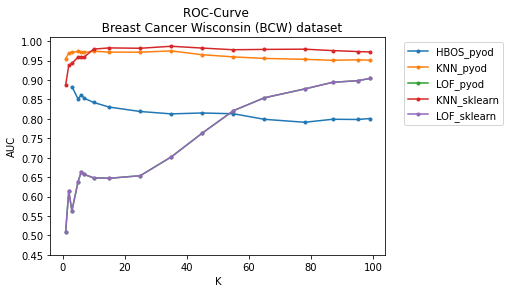

In [ ]:
#!pip install pyod
#from functions import auc_plot
import numpy as np
list_of_models = ['HBOS_pyod','KNN_pyod', 'KNN_sklearn','LOF_pyod', 'LOF_sklearn']
# k = [5, 10, 20, 30, 40, 50, 60, 70,80, 90, 100]
#k = [3,5,6,7, 10, 20, 30, 40, 50, 60, 70]
k = [1,2,3,5,6,7, 10,15, 25, 35, 45, 55, 65, 78, 87, 95, 99]
#k = np.arange(5, 100, step=10)
name_target = 'target'
contamination = 0.4
number_of_unique = None

auc_plot(df,name_target,contamination,number_of_unique,list_of_models,k)